In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [20]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

def generate_spectrogram(audio_file):
    # Load the audio file using librosa
    y, sr = librosa.load(audio_file)
    if len(y)<=16000:
        y = np.pad(y, (0,16000-len(y)), constant_values=(0,0))
    else:
        y = y[:16000]

    M = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=sr/2, n_fft=2048)
    M_db = librosa.power_to_db(M, ref=np.max)
    return M_db

def generate_dataset(folder_path):
    features = []
    labels = []
    count = 0
    for dir in os.listdir(folder_path):
        subdir = os.path.join(folder_path, dir)
        if count > 5000:
            break
        for filename in os.listdir(subdir):
            if count%500 == 0:
                print("{} samples loaded".format(count))
            count+=1
            if filename.endswith('.wav'):
                # Extract the label from the filename (the first character)
                label = int(filename[0])
                filepath = os.path.join(subdir, filename)
                # Extract the features from the audio file
                spectrogram = generate_spectrogram(filepath)
                features.append(spectrogram)
                labels.append(label)

    # Convert to numpy arrays for compatibility with most ML frameworks
    features = np.array(features)
    labels = np.array(labels)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=True)

    return X_train, X_test, y_train, y_test

In [22]:
folder_path_1 = "audioMNIST_1"
X_train, X_test, y_train, y_test = generate_dataset(folder_path_1)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

0 samples loaded
500 samples loaded
1000 samples loaded
1500 samples loaded
2000 samples loaded
2500 samples loaded
3000 samples loaded
3500 samples loaded
4000 samples loaded
4500 samples loaded
5000 samples loaded
Training samples: 4400
Testing samples: 1100


In [23]:
X_train = X_train[:400]
y_train = y_train[:400]
X_test = X_test[:100]
y_test = y_test[:100]

In [24]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [25]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 30, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 13, 64)       18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 4, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 15360)            

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
13/13 [==============================] - 7s 409ms/step - loss: 6.1307 - accuracy: 0.1475 - val_loss: 2.3231 - val_accuracy: 0.1700
Epoch 2/10
13/13 [==============================] - 4s 320ms/step - loss: 1.8933 - accuracy: 0.4150 - val_loss: 1.5796 - val_accuracy: 0.4900
Epoch 3/10
13/13 [==============================] - 5s 391ms/step - loss: 1.0270 - accuracy: 0.6950 - val_loss: 0.6227 - val_accuracy: 0.8000
Epoch 4/10
13/13 [==============================] - 6s 431ms/step - loss: 0.5115 - accuracy: 0.8700 - val_loss: 0.5150 - val_accuracy: 0.8700
Epoch 5/10
13/13 [==============================] - 4s 320ms/step - loss: 0.3456 - accuracy: 0.8950 - val_loss: 0.3490 - val_accuracy: 0.9200
Epoch 6/10
13/13 [==============================] - 5s 387ms/step - loss: 0.2282 - accuracy: 0.9300 - val_loss: 0.2875 - val_accuracy: 0.9100
Epoch 7/10
13/13 [==============================] - 5s 413ms/step - loss: 0.1290 - accuracy: 0.9575 - val_loss: 0.3121 - val_accuracy: 0.9100
Epoch 

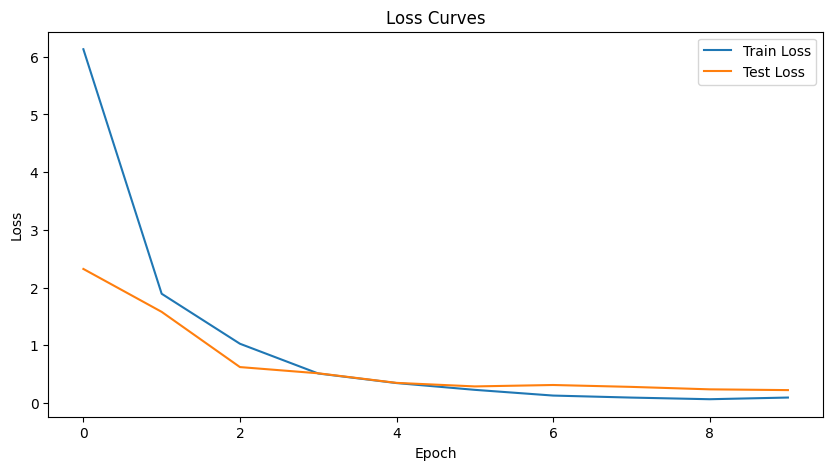

In [28]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()